<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - fine-tuning

In [1]:
!nvidia-smi

Tue Aug  2 14:24:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### import helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-02 14:27:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-02 14:27:12 (99.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### get data

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-02 14:32:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   233MB/s    in 0.7s    

2022-08-02 14:32:46 (233 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [7]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [8]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [34]:
import tensorflow as tf
IMG_SIZE = (225,225); BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
train_data, train_data.class_names

(<BatchDataset element_spec=(TensorSpec(shape=(None, 225, 225, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [21]:
#visualize a batch
for imgs, labels in train_data.take(1):
  print(imgs, labels)

tf.Tensor(
[[[[2.13120484e+00 3.13120484e+00 0.00000000e+00]
   [4.16500759e+00 5.16500759e+00 5.82503796e-01]
   [5.58572817e+00 6.58572817e+00 1.58572841e+00]
   ...
   [3.13458538e+01 3.55347252e+01 3.85347252e+01]
   [3.42600060e+01 3.52600060e+01 4.02600060e+01]
   [3.23621368e+01 3.26376915e+01 3.79999161e+01]]

  [[3.46444464e+00 4.46444464e+00 0.00000000e+00]
   [5.90582228e+00 6.90582228e+00 1.90582228e+00]
   [6.72444439e+00 7.72444439e+00 2.72444439e+00]
   ...
   [3.00327377e+01 3.50327377e+01 3.88438644e+01]
   [2.44333363e+01 2.74333363e+01 3.44333344e+01]
   [2.78191509e+01 3.08191509e+01 3.78191490e+01]]

  [[8.17333317e+00 9.17333412e+00 4.17333317e+00]
   [5.25918531e+00 6.25918531e+00 1.25918519e+00]
   [7.15321016e+00 8.15320969e+00 3.15320992e+00]
   ...
   [2.57292824e+01 3.28824806e+01 3.87293129e+01]
   [2.29991951e+01 3.00319366e+01 3.80155640e+01]
   [3.15218811e+01 3.71068535e+01 4.59335022e+01]]

  ...

  [[2.02975418e+02 1.44975418e+02 1.19754152e+01]
   [1

### experiment 1: pure feature extraction

In [25]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE)+(3,), name="input_layer") #normalizing not needed for efficientnet
x = base_model(inputs)
print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
print(x.shape)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

(None, 7, 7, 1280)
(None, 1280)


In [26]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [29]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)/4),
                    callbacks=[create_tensorboard_callback(dir_name="models",
                                                           experiment_name="feature_extraction")])

Saving TensorBoard log files to: models/feature_extraction/20220802-150358
Epoch 1/5
24/24 [==============================] - 5s 189ms/step - loss: 1.1326 - accuracy: 0.7480 - val_loss: 0.9183 - val_accuracy: 0.8174
Epoch 2/5
24/24 [==============================] - 5s 186ms/step - loss: 0.8381 - accuracy: 0.8120 - val_loss: 0.7505 - val_accuracy: 0.8470
Epoch 3/5
24/24 [==============================] - 5s 187ms/step - loss: 0.6818 - accuracy: 0.8507 - val_loss: 0.6554 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 5s 187ms/step - loss: 0.5932 - accuracy: 0.8680 - val_loss: 0.6140 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 5s 187ms/step - loss: 0.5088 - accuracy: 0.8880 - val_loss: 0.5481 - val_accuracy: 0.8618


In [37]:
model.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5757 - accuracy: 0.8452


[0.5757462382316589, 0.8452000021934509]

In [ ]:
for i,layer in enumerate(base_model.layers): print(i, layer.name)

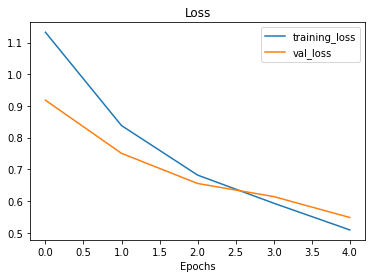

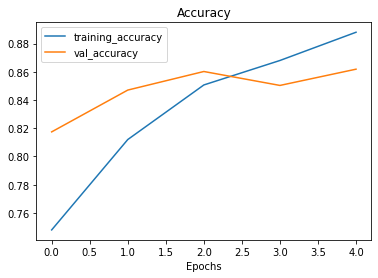

In [43]:
plot_loss_curves(history)

### getting a feature vector

In [52]:
#globalavgpool2d compresses 4-d to 2-d via averaging middle 2 axis to make a feature vector

tf.random.set_seed(42)

input_shape = (1,4,4,3)
tensor = tf.random.normal(input_shape)

pooled_tensor = tf.keras.layers.GlobalAvgPool2D()(tensor)
tensor.shape,pooled_tensor.shape


(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))